# Few-Shot Learning with Presto

### Notebook Overview 

1) Short introduction on Foundation Models and Presto
2) Definition of Few-Shot learning
3) Apply Presto to perfrom Few-Shot learning on a regression and a classification task

### 1) Foundation Models

A Foundation Model is a model trained on large and diverse unlabeled datasets to learn general patterns and features of the data. Thanks to its strong generalization capabilities, such a model can be adapted for a wide range of applications that use similar types of input data.

**Presto** (**P**retrained **Re**mote **S**ensing **T**ransf**o**rmer) is a foundation model trained on a large, unlabeled dataset of Sentinel-2, Sentinel-1, Meteorological and Topography pixel-timeseries data. It is able to capture long-range relationships across time and sensor dimensions, improving the signal-to-noise ratio and providing a concise, informative representation of the inputs. 
In this project, We made use of the Presto version developed in collaboration with [WorldCereal](https://github.com/WorldCereal/presto-worldcereal/)

Originally trained on monthly composites, Presto has been refined to be able to ingest dekadal data and to be fine-tuned for regression and classification tasks.

### 2) Few-Shot Learning

Few-shot learning aims to develop models that can learn from a small number of labeled instances while enhancing generalization and performance on new, unseen examples.

Given a dataset with only a few annotated examples, we can fine-tune a pretrained foundation model to either directly handle the downstream task or generate compressed representations of the inputs, which can then be used to train a machine learning model for the downstream task.
The figure below provides an overview of the latter scenario

<div style="text-align: center;">
    <img src="../images/ScaleAG_pipeline_overview_presto_ml.jpg" alt="Overview of a Foundation Model used to produce embeddings which can be fed as training examples to downstream models for different tasks and applications." width="700" />
    <p><em>Overview of a Foundation Model used to produce embeddings which can be fed as training examples to downstream models for different tasks and applications.</em></p>
</div>

### 3) Implementing Few-Shot learning with Presto

In [13]:
%load_ext autoreload
%autoreload 2

from loguru import logger
from pathlib import Path
import sys
sys.path.append("/home/vito/millig/gio/prometheo/")
from prometheo.datasets.scaleag import ScaleAgDataset # fix installation
from prometheo import finetune
from prometheo.finetune import Hyperparams
from prometheo.models.presto.wrapper import PretrainedPrestoWrapper, load_pretrained
from torch import nn
from scaleagdata_vito.openeo.extract_sample_scaleag import generate_extraction_job_command
from scaleagdata_vito.presto.utils import evaluate_finetuned_model
from scaleagdata_vito.presto.presto_df import load_dataset
from scaleagdata_vito.presto.utils import train_test_val_split, plot_distribution
from scaleagdata_vito.presto.inference import PrestoPredictor, reshape_result, plot_results
from scaleagdata_vito.utils.map import ui_map
from scaleagdata_vito.utils.dateslider import date_slider
from scaleagdata_vito.openeo.extract_sample_scaleag import collect_inputs_for_inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Fetch training data from OpenEO

To set up the job, we adapt the job parameters to our needs. The user has to indicate the following fields in order to generate the command to be run in the terminal for starting the extraction 

```python
job_params = dict(
    output_folder=..., 
    input_df=...,
    start_date=...,
    end_date=...,
    unique_id_column=...,
    composite_window=..., # "month" or "dekad" are supported. Default is "dekad"
)

```

In [3]:
job_params = dict(
    output_folder="/home/giorgia/Private/data/scaleag/18032025/",
    input_df="/home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson",
    start_date="2022-01-01",
    end_date="2022-12-31",
    unique_id_column="fieldname",
    composite_window="dekad",
)
generate_extraction_job_command(job_params)

python scaleag-vito/scripts/extractions/extract.py -output_folder /home/giorgia/Private/data/scaleag/18032025/ -input_df /home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson --start_date 2022-01-01 --end_date 2022-12-31 --unique_id_column fieldname --composite_window dekad


#### Regression task: potato yield estimation 

The data covers fields in Belgium and The Netherlands during the growing season. The dataset is partitioned into training, validation and test sets.

In [4]:
window_of_interest = ["2022-01-01", "2022-12-31"]
df = load_dataset(
    files_root_dir="/home/giorgia/Private/data/scaleag/18032025/",
    window_of_interest=window_of_interest,
    use_valid_time=False,
    required_min_timesteps=36,
    buffer_window=0,
    no_data_value=65535,
    composite_window="dekad",
)

100%|██████████| 544/544 [00:37<00:00, 14.64it/s]


In [5]:
df_train, df_val, df_test = train_test_val_split(parentname="fieldname", df=df, sampling_frac=0.8)

2025-04-17 16:19:35.684 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:171 - Training set size: 21659
2025-04-17 16:19:35.685 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:172 - Validation set size: 2707
2025-04-17 16:19:35.686 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:173 - Test set size: 2708


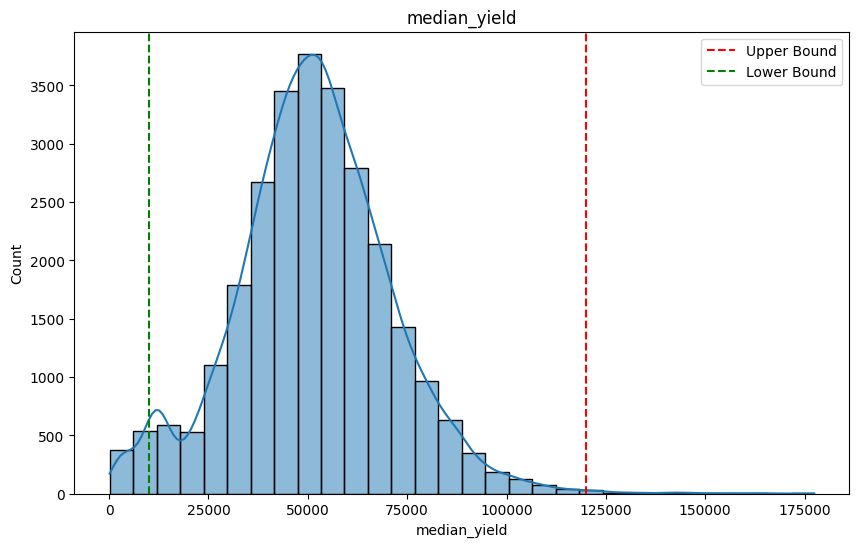

In [ ]:
# visualize distribution to check for outliers to exclude if needed
num_timesteps = df.available_timesteps.max()
task_type = "regression"
target_name = "median_yield"
compositing_window = "dekad"
upper_bound = 120000
lower_bound = 10000
plot_distribution(df, target_name, upper_bound, lower_bound)

In [7]:
# initialize datasets

train_ds = ScaleAgDataset(
    df_train,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    compositing_window=compositing_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)
val_ds = ScaleAgDataset(
    df_val,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    compositing_window=compositing_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)
test_ds = ScaleAgDataset(
    df_test,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    compositing_window=compositing_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)

2025-04-17 16:20:16.900 | INFO     | prometheo.datasets.scaleag:set_num_outputs:132 - Setting number of outputs to 1 for regression task.
2025-04-17 16:20:16.911 | INFO     | prometheo.datasets.scaleag:set_num_outputs:132 - Setting number of outputs to 1 for regression task.
2025-04-17 16:20:16.920 | INFO     | prometheo.datasets.scaleag:set_num_outputs:132 - Setting number of outputs to 1 for regression task.


#### Finetuning

In this section Presto will be Fine-Tuned in a supervised way for the target downstream task. first we set up the following experiment parameters
- `max_epochs` :
- `batch_size` :
- `num_workers` : 
- `patience` :
- `output_dir` :
- `experiment_name` :

In [8]:
# set models hyperparameters
max_epochs = 50
batch_size = 100
num_workers = 2
patience = 1 # controls the early stopping. Indicates how many epochs to wait if the valideation loss does not improve
output_dir = Path("/home/giorgia/Private/models_FSL/7042025/")
experiment_name = "presto-ss-wc-10D-ft-dek"

In [ ]:
# Construct the model with finetuning head starting from the pretrained model
pretrained_model_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ss-wc_10D.pt"
model = PretrainedPrestoWrapper(
    num_outputs=1,
    regression=True,
)
model = load_pretrained(model, pretrained_model_path, strict=False)
hyperparams = Hyperparams(max_epochs=max_epochs, batch_size=batch_size, patience=patience, num_workers=num_workers)

# set loss depending on the task type
if train_ds.task_type == "regression":
    loss_fn = nn.MSELoss()
elif train_ds.task_type == "binary":
    loss_fn = nn.BCEWithLogitsLoss()
else:
    loss_fn = nn.CrossEntropyLoss()

finetuned_model = finetune.run_finetuning(
            model,
            train_ds,
            val_ds,
            experiment_name=experiment_name,
            output_dir=output_dir,
            loss_fn=loss_fn,
            hyperparams=hyperparams,
        )

2025-04-07 10:40:31 | INFO     | prometheo.utils - Logging setup complete. Logging to: /home/giorgia/Private/models_FSL/7042025/logs/presto-ss-wc-10D-ft-dek.log and console.
2025-04-07 10:40:31 | INFO     | prometheo.finetune - Using output dir: /data/users/Private/giorgia/models_FSL/7042025


Train metric: 0.026, Val metric: 0.021, Best Val Loss: 0.021 (improved):   8%|▊         | 4/50 [12:07<2:20:24, 183.15s/it]

2025-04-07 10:55:45 | INFO     | prometheo.finetune - Early stopping!


Train metric: 0.026, Val metric: 0.021, Best Val Loss: 0.021 (improved):   8%|▊         | 4/50 [15:13<2:55:02, 228.32s/it]

2025-04-07 10:55:45 | INFO     | prometheo.finetune - Finetuning done


#### Evaluate using end-to-end finetuned Presto

In [9]:
finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=True)
finetuned_model = load_pretrained(
    finetuned_model,
    output_dir / f"{experiment_name}.pt",
)
evaluate_finetuned_model(finetuned_model, test_ds, num_workers=2, batch_size=32)

2025-04-17 16:21:12.460 | INFO     | scaleagdata_vito.presto.utils:evaluate_finetuned_model:94 - Evaluating the finetuned model on regression task


{'RMSE': 17286.44120530001,
 'R2_score': 0.20506428859164527,
 'explained_var_score': 0.2069934387603135,
 'MAPE': 0.42271903117776144}

#### Inference using Fine-Tuned end-to-end Presto

In [11]:
map = ui_map(area_limit=7)

In [12]:
# select 1 year of data
slider = date_slider()

In [ ]:
output_dir = Path("/home/giorgia/Private/scaleag_data_test/inference_extraction_test/")
output_filename = "inference_area"
inference_file = output_dir / f"{output_filename}.nc"

collect_inputs_for_inference(
    spatial_extent=map.get_extent(),
    temporal_extent=slider.get_processing_period(),
    output_path=output_dir,
    output_filename=output_filename,
    composite_window=compositing_window,
)

2025-04-17 16:40:31.138 | INFO     | scaleagdata_vito.utils.dateslider:get_processing_period:187 - Selected processing period: 2021-01-01 to 2021-12-31


Authenticated using refresh token.


2025-04-17 16:40:41,864 - openeo_gfmap.utils - INFO - Selected orbit state: ASCENDING. Reason: Orbit has more cumulative intersected area. 0.04363704677102694 > 0.042980144991678154


0:00:00 Job 'j-2504171440424531890ce4c7339b2980': send 'start'
0:00:14 Job 'j-2504171440424531890ce4c7339b2980': created (progress 0%)
0:00:19 Job 'j-2504171440424531890ce4c7339b2980': created (progress 0%)
0:00:26 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:00:34 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:00:43 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:00:56 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:01:11 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:01:30 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:01:54 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:02:24 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:03:02 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:03:49 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:04:47 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)


In [ ]:
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    compositing_window=compositing_window,
)

predictions = presto_model.predict(inference_file)
predictions_map = reshape_result(predictions, path_to_input_file=inference_file)

In [ ]:
plot_results(prob_map=predictions_map, path_to_input_file=inference_file, task=task_type, ts_index=5)

### Fine tune on crop/no-crop

In [ ]:
# from scaleagdata_vito.presto.presto_df import process_parquet

# Training parameters
pretrained_model_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
# pretrained_model_path = "/home/giorgia/Private/data/worldcereal/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
parquet_file = "/home/giorgia/Private/data/worldcereal/worldcereal_training_data.parquet"
val_samples_file = "/home/giorgia/Private/data/worldcereal/cropland_random_generalization_test_split_samples.csv"

epochs = 100
batch_size = 512
patience = 5
num_workers = 2

df = load_dataset(parquet_file).iloc[:5000]
train_df, val_df, test_df = train_test_val_split(parentname="fieldname", df=df, sampling_frac=0.8)

2025-04-07 16:28:23.055 | INFO     | __main__:load_df:66 - Reading dataset
100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


: 

In [30]:
# dataset parameters
num_timesteps = train_df.available_timesteps.max()
task_type = "binary"
target_name = "LANDCOVER_LABEL"
compositing_window = "month"
positive_labels = [10, 11, 12, 13]

In [ ]:
# initialize datasets

train_ds = ScaleAgDataset(
    train_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    positive_labels=positive_labels,
    compositing_window=compositing_window,
)

val_ds = ScaleAgDataset(
    val_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    positive_labels=positive_labels,
    compositing_window=compositing_window,
)

test_ds = ScaleAgDataset(
    test_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    positive_labels=positive_labels,
    compositing_window=compositing_window,
)

2025-04-07 16:25:42.465 | INFO     | prometheo.datasets.scaleag:set_num_outputs:132 - Setting number of outputs to 1 for binary task.
2025-04-07 16:25:42.471 | INFO     | prometheo.datasets.scaleag:set_num_outputs:132 - Setting number of outputs to 1 for binary task.


In [ ]:
from torch import nn
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader
from prometheo.finetune import Hyperparams, run_finetuning
from prometheo.models.presto import param_groups_lrd

# set loss depending on the task type
if train_ds.task_type == "regression":
    loss_fn = nn.MSELoss()
elif train_ds.task_type == "binary":
    loss_fn = nn.BCEWithLogitsLoss()
else:
    loss_fn = nn.CrossEntropyLoss()

model = PretrainedPrestoWrapper(
    num_outputs=1,
    regression=False,
    pretrained_model_path=pretrained_model_path,
)

# Set the parameters
hyperparams = Hyperparams(
    max_epochs=epochs,
    batch_size=batch_size,
    patience=patience,
    num_workers=num_workers,
)
parameters = param_groups_lrd(model)
optimizer = AdamW(parameters, lr=hyperparams.lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
experiment_name = "presto_wc_ft_crop"
# Run the finetuning
logger.info("Starting finetuning...")
finetuned_model = run_finetuning(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=experiment_name,
    output_dir=output_dir,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    hyperparams=hyperparams,
    setup_logging=False,  # Already setup logging
)

2025-04-07 16:28:55.572 | INFO     | __main__:<module>:33 - Starting finetuning...
2025-04-07 16:28:55.636 | INFO     | prometheo.finetune:_setup:171 - Using output dir: /data/users/Private/giorgia/models_FSL/7042025
Finetuning:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=True)
finetuned_model = load_pretrained(
    finetuned_model,
    output_dir / f"{experiment_name}.pt",
)
evaluate_finetuned_model(finetuned_model, test_ds, num_workers=2, batch_size=32)

#### Inference using Fine-Tuned end-to-end Presto

In [ ]:
map = ui_map(area_limit=7)

In [ ]:
# select 1 year of data
slider = date_slider()

In [ ]:
output_dir = Path("/home/giorgia/Private/scaleag_data_test/inference_extraction_test/")
output_filename = "inference_area"
inference_file = output_dir / f"{output_filename}.nc"

collect_inputs_for_inference(
    spatial_extent=map.get_extent(),
    temporal_extent=slider.get_processing_period(),
    output_path=output_dir,
    output_filename=output_filename,
    composite_window=compositing_window,
)

2025-04-17 16:40:31.138 | INFO     | scaleagdata_vito.utils.dateslider:get_processing_period:187 - Selected processing period: 2021-01-01 to 2021-12-31


Authenticated using refresh token.


2025-04-17 16:40:41,864 - openeo_gfmap.utils - INFO - Selected orbit state: ASCENDING. Reason: Orbit has more cumulative intersected area. 0.04363704677102694 > 0.042980144991678154


0:00:00 Job 'j-2504171440424531890ce4c7339b2980': send 'start'
0:00:14 Job 'j-2504171440424531890ce4c7339b2980': created (progress 0%)
0:00:19 Job 'j-2504171440424531890ce4c7339b2980': created (progress 0%)
0:00:26 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:00:34 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:00:43 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:00:56 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:01:11 Job 'j-2504171440424531890ce4c7339b2980': queued (progress 0%)
0:01:30 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:01:54 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:02:24 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:03:02 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:03:49 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)
0:04:47 Job 'j-2504171440424531890ce4c7339b2980': running (progress N/A)


In [ ]:
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    compositing_window="dekad",
)

predictions = presto_model.predict(inference_file)
predictions_map = reshape_result(predictions, path_to_input_file=inference_file)

In [ ]:
plot_results(prob_map=predictions_map, path_to_input_file=inference_file, task=task_type, ts_index=5)